In [1]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
import datetime
import matplotlib.pyplot as plt

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
torch.manual_seed(1)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 128

In [5]:
train_transform = transforms.Compose([transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
train_dataset = datasets.ImageFolder(root='datasets/kaggle/selfie2anime', transform=train_transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [6]:
def show_images(images):
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach(), nrow=22).permute(1, 2, 0))

def show_batch(dl):
    for images, _ in dl:
        show_images(images)
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


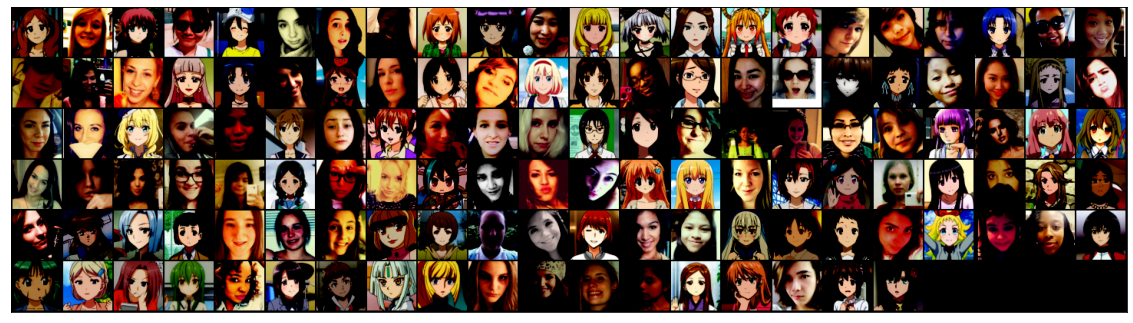

In [7]:
show_batch(train_loader)

In [8]:
image_shape = (3, 64, 64)
image_dim = int(np.prod(image_shape))
latent_dim = 100

- All the convolution-layer weights are initialized from a zero-centered normal distribution, with a standard deviation of 0.02. 
- The batch-normalization layer weights are initialized with a normal distribution, having mean 1 and a standard deviation of 0.02. The bias is initialized with zeros.

In [9]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)

<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           font-family:cursive;
           letter-spacing:0.5px;
           background-color:#ff05da;
           color:Black;
           font-family:cursive;
            padding:5px 5px 5px 5px;
           ">
<h2 style="text-align:center;font-weight: bold;">Generator Network</h2>



</div>





In [10]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        output = self.main(input)
        return output    

In [11]:
generator = Generator().to(device)
generator.apply(weights_init)
print(generator)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [12]:
summary(generator, (100,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

In [13]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
            nn.Flatten()
        )

    def forward(self, input):
        output = self.main(input)
        return output


In [14]:
discriminator = Discriminator().to(device)
discriminator.apply(weights_init)
print(discriminator)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
    (13): Flatten(start_dim=1, end_d

In [15]:
summary(discriminator, (3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]           8,192
          Sigmoid-13              [-1, 1, 1, 1]               0
          Flatten-14                   

In [16]:
adversarial_loss = nn.BCELoss() 

In [17]:
def generator_loss(fake_output, label):
    gen_loss = adversarial_loss(fake_output, label)
    return gen_loss

## The generator_loss function is fed two parameters:

- fake_output: Output predictions from the discriminator, when fed generator-produced images.
- label: Ground truth labels (1), for you would like the generator to fool the discriminator and produce real images. Hence, the labels would be one.

In [18]:
def discriminator_loss(output, label):
    disc_loss = adversarial_loss(output, label)
    return disc_loss

## The discriminator loss has:

- real (original images) output predictions, ground truth label as 1
- fake (generated images) output predictions, ground truth label as 0.

In [19]:
fixed_noise = torch.randn(128, latent_dim, 1, 1, device=device)
real_label = 1
fake_label = 0

In [20]:
learning_rate = 0.0002 
G_optimizer = optim.Adam(generator.parameters(), lr = learning_rate, betas=(0.5, 0.999))
D_optimizer = optim.Adam(discriminator.parameters(), lr = learning_rate, betas=(0.5, 0.999))

In [ ]:
# !mkdir t_weights
# !mkdir images

In [21]:
num_epochs = 500
D_loss_plot, G_loss_plot = [], []
for epoch in range(1, num_epochs+1): 

    D_loss_list, G_loss_list = [], []
   
    for index, (real_images, _) in enumerate(train_loader):
        D_optimizer.zero_grad()
        real_images = real_images.to(device)
      
        real_target = Variable(torch.ones(real_images.size(0)).to(device))
        fake_target = Variable(torch.zeros(real_images.size(0)).to(device))
        
        real_target = real_target.unsqueeze(1)
        fake_target = fake_target.unsqueeze(1)

        D_real_loss = discriminator_loss(discriminator(real_images), real_target)
        D_real_loss.backward()
    
        noise_vector = torch.randn(real_images.size(0), latent_dim, 1, 1, device=device)  
        noise_vector = noise_vector.to(device)
    
        generated_image = generator(noise_vector)
        output = discriminator(generated_image.detach())
        D_fake_loss = discriminator_loss(output,  fake_target)

        D_fake_loss.backward()
      
        D_total_loss = D_real_loss + D_fake_loss
        D_loss_list.append(D_total_loss)

        D_optimizer.step()

        
        G_optimizer.zero_grad()
        G_loss = generator_loss(discriminator(generated_image), real_target)
        G_loss_list.append(G_loss)

        G_loss.backward()
        G_optimizer.step()


    print('Epoch: [%d/%d]: D_loss: %.3f, G_loss: %.3f' % (
            (epoch), num_epochs, torch.mean(torch.FloatTensor(D_loss_list)),\
             torch.mean(torch.FloatTensor(G_loss_list))))
    
    D_loss_plot.append(torch.mean(torch.FloatTensor(D_loss_list)))
    G_loss_plot.append(torch.mean(torch.FloatTensor(G_loss_list)))
    save_image(generated_image.data[:50], './images/sample_%d'%epoch + '.png', nrow=5, normalize=True)
     
    torch.save(generator.state_dict(), './t_weights/generator_epoch_%d.pth' % (epoch))
    torch.save(discriminator.state_dict(), './t_weights/discriminator_epoch_%d.pth' % (epoch))

Epoch: [1/500]: D_loss: 0.624, G_loss: 13.547
Epoch: [2/500]: D_loss: 0.922, G_loss: 8.642
Epoch: [3/500]: D_loss: 0.721, G_loss: 5.793
Epoch: [4/500]: D_loss: 0.756, G_loss: 6.988
Epoch: [5/500]: D_loss: 0.636, G_loss: 5.037
Epoch: [6/500]: D_loss: 0.642, G_loss: 4.917
Epoch: [7/500]: D_loss: 0.722, G_loss: 4.940
Epoch: [8/500]: D_loss: 0.648, G_loss: 4.704
Epoch: [9/500]: D_loss: 0.597, G_loss: 5.017
Epoch: [10/500]: D_loss: 0.762, G_loss: 4.380
Epoch: [11/500]: D_loss: 0.566, G_loss: 4.795
Epoch: [12/500]: D_loss: 0.651, G_loss: 5.083
Epoch: [13/500]: D_loss: 0.691, G_loss: 4.760
Epoch: [14/500]: D_loss: 0.660, G_loss: 4.542
Epoch: [15/500]: D_loss: 0.583, G_loss: 4.507
Epoch: [16/500]: D_loss: 0.587, G_loss: 4.844
Epoch: [17/500]: D_loss: 0.572, G_loss: 4.532
Epoch: [18/500]: D_loss: 0.562, G_loss: 4.691
Epoch: [19/500]: D_loss: 0.429, G_loss: 4.623
Epoch: [20/500]: D_loss: 0.763, G_loss: 4.741
Epoch: [21/500]: D_loss: 0.499, G_loss: 4.705
Epoch: [22/500]: D_loss: 0.696, G_loss: 4.

In [22]:
def getImagePaths(path):
    image_names = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            image_names.append(fullpath)
    return image_names

In [23]:
import cv2
def display_multiple_img(images_paths, rows, cols):
    figure, ax = plt.subplots(nrows=rows,ncols=cols,figsize=(500,100) )
    for ind,image_path in enumerate(images_paths):
        image=cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        try:
            ax.ravel()[ind].imshow(image)
            ax.ravel()[ind].set_axis_off()
        except:
            continue;
    plt.tight_layout()
    plt.show()

In [25]:
display_multiple_img(getImagePaths('./images'),num_epochs//2 , 2)

In [ ]:
images = [
    "/kaggle/input/selfie2anime/testA/female_14491.jpg",
    "/kaggle/input/selfie2anime/testA/female_15512.jpg",
    "/kaggle/input/selfie2anime/testA/female_32812.jpg",
    "/kaggle/input/selfie2anime/testA/female_2321.jpg",
    "/kaggle/input/selfie2anime/testA/female_4197.jpg"
]
for path in images:
    raw = load_image(path)
    real = mx.image.resize_short(raw, 256)
    real = mx.nd.image.normalize(mx.nd.image.to_tensor(real), mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    real = real.expand_dims(0)
    fake, _ = gen(real)
    plt.subplot(1, 2, 1)
    plt.imshow(raw.asnumpy())
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(reconstruct_color(fake[0].transpose((1, 2, 0))).asnumpy())
    plt.axis("off")
    plt.show()